# `AZDIAS` + `CUSTOMERS` dataset

# 00. Importing packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
try:
    from tqdm import tqdm
except:
    !pip install tqdm
    from tqdm import tqdm    
%matplotlib inline


### my utils
from sklearn.preprocessing import OrdinalEncoder
from eda_utils import *

# 01. Loading datasets

In [2]:
customers = pd.read_csv("../arvato_data_processed/customers.csv", low_memory = False, index_col = 'LNR')
azdias = pd.read_csv("../arvato_data_processed/azdias.csv", low_memory = False, index_col = 'LNR')

customers_feature_types =  pd.read_csv("../arvato_data_processed/customers_feature_types.csv", low_memory = False,index_col='Attribute' )
azdias_feature_types =  pd.read_csv("../arvato_data_processed/azdias_feature_types.csv", low_memory = False,index_col='Attribute' )

print(customers_feature_types.shape,azdias_feature_types.shape)

customers_features = set(customers_feature_types['Attribute.1'])
azdias_features = set(azdias_feature_types['Attribute.1']) 

(333, 2) (332, 2)


# 02. Common features

In [3]:
common_features=  customers_features.intersection(azdias_features)
len(common_features)

330

We have 330 features in common, let's see what features are missing. We know from previous notebooks that `customers` initially had 3 more features than `azdias` dataset:

In [4]:
customers_features.difference(azdias_features)

{'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'}

In [5]:
azdias_features.difference(customers_features)

{'KKK', 'REGIOTYP'}

So, after applying filtering for missingness in `azdias` and `customers` we have 330 common features.

Three features present in `customers` are lacking entires in `azdias`:
1. `CUSTOMER_GROUP`
2. `ONLINE_PURCHASE`
3. `PRODUCT_GROUP`

These features are related to the customer-related information for which we **naturally don't have general population equivalent**: 1. what is the group of the customer (single/multiple buyer), 2. whether it bought something online from us, 3. what category of product was it

Whereas customers lack two features present in general population:

1. `KKK` - purchasing power
2. `REGIOTYP` - neighbourhood, one of several possible classes: unknown, upper class, conservatives, upper middle class, middle class, lower middle class, traditional workers, marginal groups

In [6]:
azdias = azdias[common_features]
customers = customers[common_features]

In [7]:
customers['dataset'] = 'customers'
azdias['dataset'] = 'azdias'

In [8]:
joint_dataset = pd.concat([customers,azdias])
assert customers.shape[0]+azdias.shape[0]==joint_dataset.shape[0]

joint_dataset.head(5)

,D19_LEBENSMITTEL_RZ,KBA05_HERST4,SEMIO_SOZ,D19_GESAMT_ONLINE_QUOTE_12,KBA13_FAB_ASIEN,KBA05_ALTER2,D19_VERSAND_REST_RZ,KBA05_MOD3,KBA05_CCM2,KBA05_ZUL2,...,KBA05_KRSHERST2,GFK_URLAUBERTYP,WOHNLAGE,ANZ_STATISTISCHE_HAUSHALTE,KBA13_HALTER_30,KBA13_SITZE_6,KBA05_MOTOR,KBA13_BAUMAX,KBA13_ANTG3,dataset
LNR,,,,,,,,,,,,,,,,,,,,,
9626,6,2.0,6,0.0,2.0,2.0,0,3.0,3.0,4.0,...,3.0,4.0,7.0,1.0,1.0,5.0,4.0,1.0,1.0,customers
143872,0,2.0,2,0.0,3.0,4.0,0,4.0,2.0,4.0,...,4.0,3.0,2.0,1.0,4.0,4.0,4.0,3.0,3.0,customers
143873,0,5.0,6,0.0,4.0,3.0,0,5.0,4.0,3.0,...,2.0,10.0,7.0,1.0,3.0,3.0,2.0,1.0,0.0,customers
143874,5,2.0,4,10.0,4.0,4.0,3,3.0,5.0,3.0,...,4.0,2.0,3.0,7.0,1.0,3.0,2.0,2.0,2.0,customers
143888,0,3.0,6,0.0,3.0,2.0,0,1.0,2.0,3.0,...,4.0,11.0,1.0,1.0,3.0,5.0,4.0,1.0,2.0,customers


In [11]:
msg = "The joint dataset has {} rows. The first {} rows are coming from customers dataset, the latter {} come from general population, i.e. AZDIAS dataset".format(
joint_dataset.shape[0], customers.shape[0],azdias.shape[0])
print(msg)

The joint dataset has 932108 rows. The first 140864 rows are coming from customers dataset, the latter 791244 come from general population, i.e. AZDIAS dataset


In [13]:
joint_dataset.shape[0] == customers.shape[0]+azdias.shape[0]

True

In [9]:
# free memory
del customers
del azdias

# 03. Features

## 03.01. Standardizing features

Upon inspecting metadata attributes in `DIAS Attributes - Values 2017.xlsx` I've found that there are a couple of features that need re-encoding:

- `LP_FAMILIE_GROB` must be standardized. As initially there are multiple labels that refer to the same class!
    - from documentation: 
     ```
     1 -> single
     2 - > couple
     3,4,5 -> single parent
     6,7,8 -> family
     9,10,11 -> multiperson household
     
     ```
     
     
I will replace all secondary values for a class with the first value of a class. Also, there seems to be a value `0` present, but for which we don't have any information, I'll replace `0` with NA

In [10]:

print("Before standarization we have classes: {}".format(np.unique(joint_dataset['LP_FAMILIE_GROB'].dropna())))


joint_dataset['LP_FAMILIE_GROB'].replace(4,3,inplace=True)
joint_dataset['LP_FAMILIE_GROB'].replace(5,3,inplace=True)

joint_dataset['LP_FAMILIE_GROB'].replace(7,6,inplace=True)
joint_dataset['LP_FAMILIE_GROB'].replace(8,6,inplace=True)

joint_dataset['LP_FAMILIE_GROB'].replace(10,9,inplace=True)
joint_dataset['LP_FAMILIE_GROB'].replace(11,9,inplace=True)

joint_dataset['LP_FAMILIE_GROB'].replace(0,np.nan,inplace=True)


print("After standarization we have classes: {}".format(np.unique(joint_dataset['LP_FAMILIE_GROB'].dropna())))


Before standarization we have classes: [0. 1. 2. 3. 4. 5.]
After standarization we have classes: [1. 2. 3.]


- `LP_STATUS_GROB` is a feature that encodes the same class with different labels. From the provided metadata in Exel file we know:
   ```
   1,2 - > low-income earners
   3,4,5 -> average,erners
   6,7 -> independants
   8,9 -> houseowners
   10 -> top earners
   
   ```
   

In [11]:
print("Before standarization we have classes: {}".format(np.unique(joint_dataset['LP_STATUS_GROB'].dropna())))

joint_dataset['LP_STATUS_GROB'].replace(2,1,inplace=True)

joint_dataset['LP_STATUS_GROB'].replace(4,3,inplace=True)
joint_dataset['LP_STATUS_GROB'].replace(5,3,inplace=True)

joint_dataset['LP_STATUS_GROB'].replace(7,6,inplace=True)

joint_dataset['LP_STATUS_GROB'].replace(9,8,inplace=True)

print("After standarization we have classes: {}".format(np.unique(joint_dataset['LP_STATUS_GROB'].dropna())))


Before standarization we have classes: [1. 2. 3. 4. 5.]
After standarization we have classes: [1. 3.]


- `PRAEGENDE_JUGENDJAHRE` could be simplified, thus I create a new feature: `PRAEGENDE_JUGENDJAHRE_SIM` to collapse a couple of classes together based on metadata:


initial classes:
```
1	40ies - war years (Mainstream, O+W)
2	40ies - reconstruction years (Avantgarde, O+W)
3	50ies - economic miracle (Mainstream, O+W)
4	50ies - milk bar / Individualisation (Avantgarde, O+W)
5	60ies - economic miracle (Mainstream, O+W)
6	60ies - generation 68 / student protestors (Avantgarde, W)
7	60ies - opponents to the building of the Wall (Avantgarde, O)
8	70ies - family orientation (Mainstream, O+W)
9	70ies - peace movement (Avantgarde, O+W)
10	80ies - Generation Golf (Mainstream, W)
11	80ies - ecological awareness (Avantgarde, W)
12	80ies - FDJ / communist party youth organisation (Mainstream, O)
13	80ies - Swords into ploughshares (Avantgarde, O)
14	90ies - digital media kids (Mainstream, O+W)
15	90ies - ecological awareness (Avantgarde, O+W)
```
simplified classes:

```
    1,2 -> 40ies
    3,4 -> 50ies
    5,6,7 -> 60ies
    8,9 -> 70ies
    10,11,12,13 -: 80ies
    14,15 -> 90ies

```


In [12]:
joint_dataset['PRAEGENDE_JUGENDJAHRE_SIM']= joint_dataset['PRAEGENDE_JUGENDJAHRE']

print("Before standarization we have classes: {}".format(np.unique(joint_dataset['PRAEGENDE_JUGENDJAHRE'].dropna())))

joint_dataset['PRAEGENDE_JUGENDJAHRE_SIM'].replace(2,1,inplace=True)

joint_dataset['PRAEGENDE_JUGENDJAHRE_SIM'].replace(4,3,inplace=True)

joint_dataset['PRAEGENDE_JUGENDJAHRE_SIM'].replace(6,5,inplace=True)
joint_dataset['PRAEGENDE_JUGENDJAHRE_SIM'].replace(7,5,inplace=True)
 
joint_dataset['PRAEGENDE_JUGENDJAHRE_SIM'].replace(9,8,inplace=True)


joint_dataset['PRAEGENDE_JUGENDJAHRE_SIM'].replace(11,10,inplace=True)
joint_dataset['PRAEGENDE_JUGENDJAHRE_SIM'].replace(12,10,inplace=True)
joint_dataset['PRAEGENDE_JUGENDJAHRE_SIM'].replace(13,10,inplace=True)


joint_dataset['PRAEGENDE_JUGENDJAHRE_SIM'].replace(15,14,inplace=True)

print("After standarization we have classes: {}".format(np.unique(joint_dataset['PRAEGENDE_JUGENDJAHRE_SIM'].dropna())))


Before standarization we have classes: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]
After standarization we have classes: [ 1.  3.  5.  8. 10. 14.]


- `CAMEO_DEUINTL_2015` can be also generalized/simplified: to `CAMEO_DEUINTL_2015_SIM`

original annotations
```
11	Wealthy Households-Pre-Family Couples & Singles
12	Wealthy Households-Young Couples With Children
13	Wealthy Households-Families With School Age Children
14	Wealthy Households-Older Families &  Mature Couples
15	Wealthy Households-Elders In Retirement
21	Prosperous Households-Pre-Family Couples & Singles
22	Prosperous Households-Young Couples With Children
23	Prosperous Households-Families With School Age Children
24	Prosperous Households-Older Families & Mature Couples
25	Prosperous Households-Elders In Retirement
31	Comfortable Households-Pre-Family Couples & Singles
32	Comfortable Households-Young Couples With Children
33	Comfortable Households-Families With School Age Children
34	Comfortable Households-Older Families & Mature Couples
35	Comfortable Households-Elders In Retirement
41	Less Affluent Households-Pre-Family Couples & Singles
42	Less Affluent Households-Young Couples With Children
43	Less Affluent Households-Families With School Age Children
44	Less Affluent Households-Older Families & Mature Couples
45	Less Affluent Households-Elders In Retirement
51	Poorer Households-Pre-Family Couples & Singles
52	Poorer Households-Young Couples With Children
53	Poorer Households-Families With School Age Children
54	Poorer Households-Older Families & Mature Couples
55	Poorer Households-Elders In Retirement

```

simplified:

```
11,12,13,14,15 -> wealthy

21,22,23,24,25 -> prosperous

31,32,33,34,35 -> comfortable

41,42,43,44,45 -> less affluent

51,52,53,54,55 -> poorer

```

also, the `XX` is replaced as unknown:

In [13]:
joint_dataset['CAMEO_DEUINTL_2015_SIM'] = joint_dataset['CAMEO_DEUINTL_2015']

 
    
print("Before standarization we have classes: {}".format(np.unique(joint_dataset['CAMEO_DEUINTL_2015_SIM'].dropna())))

joint_dataset['CAMEO_DEUINTL_2015_SIM'].replace('12','11',inplace=True)
joint_dataset['CAMEO_DEUINTL_2015_SIM'].replace('13','11',inplace=True)
joint_dataset['CAMEO_DEUINTL_2015_SIM'].replace('14','11',inplace=True)
joint_dataset['CAMEO_DEUINTL_2015_SIM'].replace('15','11',inplace=True)
 
joint_dataset['CAMEO_DEUINTL_2015_SIM'].replace('22','21',inplace=True)
joint_dataset['CAMEO_DEUINTL_2015_SIM'].replace('23','21',inplace=True)
joint_dataset['CAMEO_DEUINTL_2015_SIM'].replace('24','21',inplace=True)
joint_dataset['CAMEO_DEUINTL_2015_SIM'].replace('25','21',inplace=True)
 
joint_dataset['CAMEO_DEUINTL_2015_SIM'].replace('32','31',inplace=True)
joint_dataset['CAMEO_DEUINTL_2015_SIM'].replace('33','31',inplace=True)
joint_dataset['CAMEO_DEUINTL_2015_SIM'].replace('34','31',inplace=True)
joint_dataset['CAMEO_DEUINTL_2015_SIM'].replace('35','31',inplace=True)

joint_dataset['CAMEO_DEUINTL_2015_SIM'].replace('42','41',inplace=True)
joint_dataset['CAMEO_DEUINTL_2015_SIM'].replace('43','41',inplace=True)
joint_dataset['CAMEO_DEUINTL_2015_SIM'].replace('44','41',inplace=True)
joint_dataset['CAMEO_DEUINTL_2015_SIM'].replace('45','41',inplace=True)

joint_dataset['CAMEO_DEUINTL_2015_SIM'].replace('52','51',inplace=True)
joint_dataset['CAMEO_DEUINTL_2015_SIM'].replace('53','51',inplace=True)
joint_dataset['CAMEO_DEUINTL_2015_SIM'].replace('54','51',inplace=True)
joint_dataset['CAMEO_DEUINTL_2015_SIM'].replace('55','51',inplace=True)
    
joint_dataset['CAMEO_DEUINTL_2015_SIM'].replace('XX',np.nan,inplace=True)    
    
print("After standarization we have classes: {}".format(np.unique(joint_dataset['CAMEO_DEUINTL_2015_SIM'].dropna())))


Before standarization we have classes: ['12' '13' '14' '15' '22' '23' '24' '25' '31' '32' '33' '34' '35' '41'
 '43' '44' '45' '51' '52' '54' '55' 'XX']
After standarization we have classes: ['11' '21' '31' '41' '51']


- encode (check types)
- impute
- correlate
- save independent?

## 03.02. Encode Features

joint dataset comprises of three types of features: 

1. numerical - will be left unchanged
2. ordinal - will be encoded with label encoder
3. categorical -> will be encoded with label encoder


I will encode ordinal and categorical features as standardized integers. As seen above some classes comprise of high-value numbers.

In [14]:
# Assert that the feature types in AZDIAS and Customers are the same for ALL
common_features = pd.merge(customers_feature_types,azdias_feature_types,on='Attribute.1')

# pandas dataframe containing differences in types must have 0 rows, i.e. no different datatypes for the same features
assert common_features[common_features['Type_x']!=common_features["Type_y"]].shape[0]==0


Extract feature names that **ARE NOT NUMERICAL** (that need label encoding)

In [15]:
str_features = list(common_features[common_features['Type_x']!='numerical']['Attribute.1'])

# two newly created features
str_features.append('PRAEGENDE_JUGENDJAHRE_SIM')
str_features.append('CAMEO_DEUINTL_2015_SIM')
str_features = list(set(str_features))
len(str_features)

324

In [16]:
from sklearn.preprocessing import LabelEncoder
LabelEncoders = { x: LabelEncoder() for x in str_features  }

CPU times: user 702 ms, sys: 83.8 ms, total: 785 ms
Wall time: 807 ms


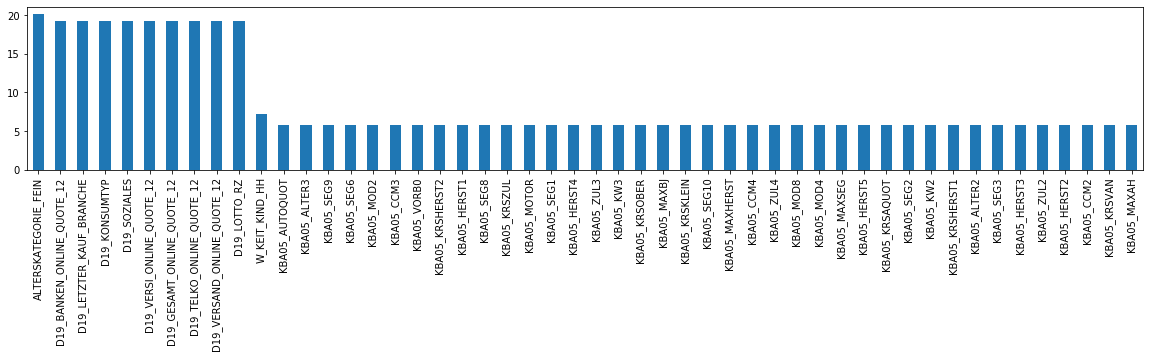

In [17]:
%%time
empty_cells = pd.isnull(joint_dataset).sum()*100.0/joint_dataset.shape[0]
empty_cells = empty_cells.sort_values(ascending=False)
empty_cells[:50].plot(figsize=(20,3),kind='bar') # bar plot of first 50 most missing features

In [18]:
for idx,feature in enumerate(str_features):
    print("{}/{}: {}".format(idx+1,len(str_features),feature ))
    
    # NA mask - label encoder cannot handle missing values (i.e. NAs)
    not_na_mask =  joint_dataset[feature].notnull() # FALSE for NA, TRUE for some value
    
    joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )

1/324: WOHNLAGE
2/324: KBA13_KW_50
3/324: SEMIO_RAT
4/324: KBA05_SEG5


<ipython-input-18-14e690ed7ce1>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )


5/324: FINANZ_HAUSBAUER
6/324: FINANZTYP
7/324: GEMEINDETYP
8/324: KBA13_KRSHERST_AUDI_VW
9/324: D19_BUCH_RZ
10/324: KBA13_CCM_1600
11/324: KBA13_CCM_2500
12/324: LP_STATUS_FEIN
13/324: KBA13_HALTER_35
14/324: KBA13_FIAT
15/324: KBA05_CCM1
16/324: D19_RATGEBER_RZ
17/324: FINANZ_MINIMALIST
18/324: D19_VERSAND_ONLINE_QUOTE_12
19/324: D19_BANKEN_DIREKT_RZ
20/324: D19_VOLLSORTIMENT_RZ
21/324: KBA05_KRSOBER
22/324: D19_KONSUMTYP
23/324: VERDICHTUNGSRAUM
24/324: KBA05_SEG9
25/324: KBA13_BJ_2008
26/324: FIRMENDICHTE
27/324: STRUKTURTYP
28/324: KBA05_SEG8
29/324: GREEN_AVANTGARDE
30/324: KOMBIALTER
31/324: KBA05_VORB0
32/324: KBA13_KMH_211
33/324: VHA
34/324: KBA05_ALTER1
35/324: D19_VERSI_ONLINE_DATUM
36/324: KBA13_HERST_EUROPA
37/324: KBA13_HERST_FORD_OPEL
38/324: VERS_TYP
39/324: KBA13_KW_110
40/324: CJT_TYP_6
41/324: EINGEZOGENAM_HH_JAHR
42/324: KBA05_ANTG3
43/324: KONSUMZELLE
44/324: D19_SOZIALES
45/324: D19_VERSI_ONLINE_QUOTE_12
46/324: KBA13_FORD
47/324: KBA13_MAZDA
48/324: ALTERSKATEGO

CPU times: user 668 ms, sys: 88.2 ms, total: 756 ms
Wall time: 754 ms


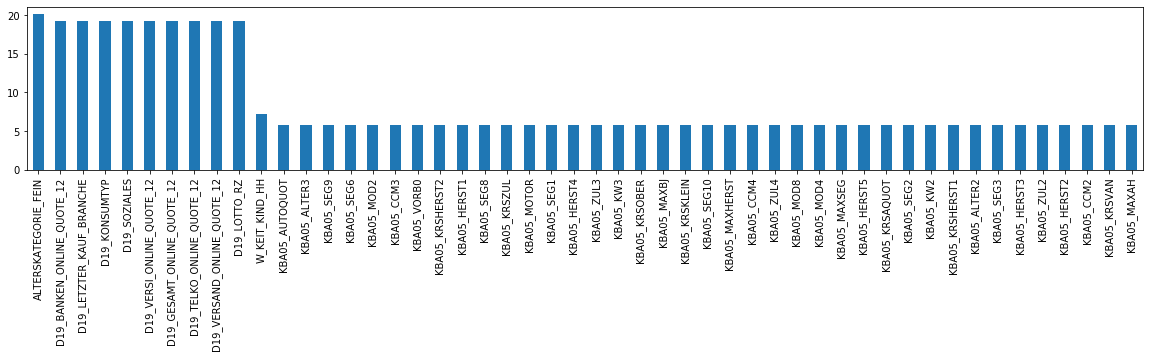

In [19]:
%%time
empty_cells = pd.isnull(joint_dataset).sum()*100.0/joint_dataset.shape[0]
empty_cells = empty_cells.sort_values(ascending=False)
empty_cells[:50].plot(figsize=(20,3),kind='bar') # bar plot of first 50 most missing features

## 03.02 Impute features

In [20]:
joint_dataset.drop('dataset',inplace=True,axis='columns')

In [21]:
%%time
import sklearn 
from sklearn.experimental import enable_iterative_imputer
print('The scikit-learn version is {}.'.format(sklearn.__version__))
from sklearn.impute import IterativeImputer

ie = IterativeImputer(n_nearest_features=10) # 10 is fine, takes around __ minutes on my computer

joint_dataset_imputed = ie.fit_transform(joint_dataset) # ~20min, returns numpy array
joint_dataset_imputed_df = pd.DataFrame(joint_dataset_imputed, columns= joint_dataset.columns )


The scikit-learn version is 0.22.1.


/home/robert_remote/anaconda3/envs/mlend/lib/python3.8/site-packages/sklearn/impute/_iterative.py:637: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


CPU times: user 1h 45min 59s, sys: 2min 11s, total: 1h 48min 10s
Wall time: 14min 14s


We've used an `InterativeImputer` for numerical and ordinal/categorical features. For the latter the imputer treated them as numerical values, and due to the nature of Bayesian imputation, these values would not necessarily be intigers. In the next step I round the values for categories to the closes integer corresponding to that class.



In [22]:
for i,feature in enumerate(str_features):
    print("{}/{} {}".format(i+1,len(str_features), feature))
    joint_dataset_imputed_df[feature] = joint_dataset_imputed_df[feature].round()

1/324 WOHNLAGE
2/324 KBA13_KW_50
3/324 SEMIO_RAT
4/324 KBA05_SEG5
5/324 FINANZ_HAUSBAUER
6/324 FINANZTYP
7/324 GEMEINDETYP
8/324 KBA13_KRSHERST_AUDI_VW
9/324 D19_BUCH_RZ
10/324 KBA13_CCM_1600
11/324 KBA13_CCM_2500
12/324 LP_STATUS_FEIN
13/324 KBA13_HALTER_35
14/324 KBA13_FIAT
15/324 KBA05_CCM1
16/324 D19_RATGEBER_RZ
17/324 FINANZ_MINIMALIST
18/324 D19_VERSAND_ONLINE_QUOTE_12
19/324 D19_BANKEN_DIREKT_RZ
20/324 D19_VOLLSORTIMENT_RZ
21/324 KBA05_KRSOBER
22/324 D19_KONSUMTYP
23/324 VERDICHTUNGSRAUM
24/324 KBA05_SEG9
25/324 KBA13_BJ_2008
26/324 FIRMENDICHTE
27/324 STRUKTURTYP
28/324 KBA05_SEG8
29/324 GREEN_AVANTGARDE
30/324 KOMBIALTER
31/324 KBA05_VORB0
32/324 KBA13_KMH_211
33/324 VHA
34/324 KBA05_ALTER1
35/324 D19_VERSI_ONLINE_DATUM
36/324 KBA13_HERST_EUROPA
37/324 KBA13_HERST_FORD_OPEL
38/324 VERS_TYP
39/324 KBA13_KW_110
40/324 CJT_TYP_6
41/324 EINGEZOGENAM_HH_JAHR
42/324 KBA05_ANTG3
43/324 KONSUMZELLE
44/324 D19_SOZIALES
45/324 D19_VERSI_ONLINE_QUOTE_12
46/324 KBA13_FORD
47/324 KBA13_MAZ

# TODO
- save the scalers

And now compare the number of unique classes before and after imputation:

In [23]:
imputed_features_counts = {}
imputed_features_counts['Attribute'] =[]
imputed_features_counts['Before_imputation'] =[]
imputed_features_counts['After_imputation'] =[]

for idx,f in enumerate(str_features):
    print("{}/{}: {}".format(idx+1,len(str_features),f))
    
    imputed_features_counts['Attribute'].append(f)

    uniq_before = len(np.unique(joint_dataset[f].dropna() ))
    imputed_features_counts['Before_imputation'].append(uniq_before)
    
    uniq_after =   len(np.unique(joint_dataset_imputed_df[f].dropna() ))
    imputed_features_counts['After_imputation'].append(uniq_after)
    
imputed_features_counts = pd.DataFrame.from_dict(imputed_features_counts)
imputed_features_counts.sort_values('Before_imputation',ascending=False, inplace=True)
imputed_features_counts

1/324: WOHNLAGE
2/324: KBA13_KW_50
3/324: SEMIO_RAT
4/324: KBA05_SEG5
5/324: FINANZ_HAUSBAUER
6/324: FINANZTYP
7/324: GEMEINDETYP
8/324: KBA13_KRSHERST_AUDI_VW
9/324: D19_BUCH_RZ
10/324: KBA13_CCM_1600
11/324: KBA13_CCM_2500
12/324: LP_STATUS_FEIN
13/324: KBA13_HALTER_35
14/324: KBA13_FIAT
15/324: KBA05_CCM1
16/324: D19_RATGEBER_RZ
17/324: FINANZ_MINIMALIST
18/324: D19_VERSAND_ONLINE_QUOTE_12
19/324: D19_BANKEN_DIREKT_RZ
20/324: D19_VOLLSORTIMENT_RZ
21/324: KBA05_KRSOBER
22/324: D19_KONSUMTYP
23/324: VERDICHTUNGSRAUM
24/324: KBA05_SEG9
25/324: KBA13_BJ_2008
26/324: FIRMENDICHTE
27/324: STRUKTURTYP
28/324: KBA05_SEG8
29/324: GREEN_AVANTGARDE
30/324: KOMBIALTER
31/324: KBA05_VORB0
32/324: KBA13_KMH_211
33/324: VHA
34/324: KBA05_ALTER1
35/324: D19_VERSI_ONLINE_DATUM
36/324: KBA13_HERST_EUROPA
37/324: KBA13_HERST_FORD_OPEL
38/324: VERS_TYP
39/324: KBA13_KW_110
40/324: CJT_TYP_6
41/324: EINGEZOGENAM_HH_JAHR
42/324: KBA05_ANTG3
43/324: KONSUMZELLE
44/324: D19_SOZIALES
45/324: D19_VERSI_ONLIN

,Attribute,Before_imputation,After_imputation
22,VERDICHTUNGSRAUM,46,47
53,CAMEO_DEU_2015,45,45
60,LP_LEBENSPHASE_FEIN,41,41
40,EINGEZOGENAM_HH_JAHR,37,37
97,D19_LETZTER_KAUF_BRANCHE,35,35
...,...,...,...
28,GREEN_AVANTGARDE,2,2
129,ANREDE_KZ,2,2
250,UNGLEICHENN_FLAG,2,2
42,KONSUMZELLE,2,2


In [24]:
imputed_features_counts[imputed_features_counts['Before_imputation']!=imputed_features_counts['After_imputation']]

,Attribute,Before_imputation,After_imputation
22,VERDICHTUNGSRAUM,46,47
206,PRAEGENDE_JUGENDJAHRE,15,16
121,LP_FAMILIE_FEIN,12,13
143,VK_ZG11,11,12
67,D19_BANKEN_ONLINE_QUOTE_12,11,12
158,D19_GESAMT_ONLINE_QUOTE_12,11,15
17,D19_VERSAND_ONLINE_QUOTE_12,11,14
11,LP_STATUS_FEIN,10,14
21,D19_KONSUMTYP,7,8
6,GEMEINDETYP,7,8


As we can see some features exhibited more classes than anticipated. I will replace the new numerical labels for classes as unknowns

In [25]:
# replace seemingly new classes with NANs
for idx,feature in enumerate(str_features):
    print("{}/{}: {}".format(idx+1,len(str_features),feature))
    imputed_clusters = np.unique(joint_dataset_imputed_df[feature].dropna())
    original_clusters = np.unique(joint_dataset[feature].dropna())


    unobserved_classes = set(imputed_clusters).difference( set(original_clusters) )
    for uclass in unobserved_classes:
        joint_dataset_imputed_df[feature].replace(uclass,np.nan, inplace=True)
        

1/324: WOHNLAGE
2/324: KBA13_KW_50
3/324: SEMIO_RAT
4/324: KBA05_SEG5
5/324: FINANZ_HAUSBAUER
6/324: FINANZTYP
7/324: GEMEINDETYP
8/324: KBA13_KRSHERST_AUDI_VW
9/324: D19_BUCH_RZ
10/324: KBA13_CCM_1600
11/324: KBA13_CCM_2500
12/324: LP_STATUS_FEIN
13/324: KBA13_HALTER_35
14/324: KBA13_FIAT
15/324: KBA05_CCM1
16/324: D19_RATGEBER_RZ
17/324: FINANZ_MINIMALIST
18/324: D19_VERSAND_ONLINE_QUOTE_12
19/324: D19_BANKEN_DIREKT_RZ
20/324: D19_VOLLSORTIMENT_RZ
21/324: KBA05_KRSOBER
22/324: D19_KONSUMTYP
23/324: VERDICHTUNGSRAUM
24/324: KBA05_SEG9
25/324: KBA13_BJ_2008
26/324: FIRMENDICHTE
27/324: STRUKTURTYP
28/324: KBA05_SEG8
29/324: GREEN_AVANTGARDE
30/324: KOMBIALTER
31/324: KBA05_VORB0
32/324: KBA13_KMH_211
33/324: VHA
34/324: KBA05_ALTER1
35/324: D19_VERSI_ONLINE_DATUM
36/324: KBA13_HERST_EUROPA
37/324: KBA13_HERST_FORD_OPEL
38/324: VERS_TYP
39/324: KBA13_KW_110
40/324: CJT_TYP_6
41/324: EINGEZOGENAM_HH_JAHR
42/324: KBA05_ANTG3
43/324: KONSUMZELLE
44/324: D19_SOZIALES
45/324: D19_VERSI_ONLIN

In [26]:
imputed_features_counts = {}
imputed_features_counts['Attribute'] =[]
imputed_features_counts['Before_imputation'] =[]
imputed_features_counts['After_imputation'] =[]

for idx,f in enumerate(str_features):
    print("{}/{}: {}".format(idx+1,len(str_features),f))
    
    imputed_features_counts['Attribute'].append(f)

    uniq_before = len(np.unique(joint_dataset[f].dropna() ))
    imputed_features_counts['Before_imputation'].append(uniq_before)
    
    uniq_after =   len(np.unique(joint_dataset_imputed_df[f].dropna() ))
    imputed_features_counts['After_imputation'].append(uniq_after)
    
imputed_features_counts = pd.DataFrame.from_dict(imputed_features_counts)
imputed_features_counts.sort_values('Before_imputation',ascending=False, inplace=True)
imputed_features_counts

1/324: WOHNLAGE
2/324: KBA13_KW_50
3/324: SEMIO_RAT
4/324: KBA05_SEG5
5/324: FINANZ_HAUSBAUER
6/324: FINANZTYP
7/324: GEMEINDETYP
8/324: KBA13_KRSHERST_AUDI_VW
9/324: D19_BUCH_RZ
10/324: KBA13_CCM_1600
11/324: KBA13_CCM_2500
12/324: LP_STATUS_FEIN
13/324: KBA13_HALTER_35
14/324: KBA13_FIAT
15/324: KBA05_CCM1
16/324: D19_RATGEBER_RZ
17/324: FINANZ_MINIMALIST
18/324: D19_VERSAND_ONLINE_QUOTE_12
19/324: D19_BANKEN_DIREKT_RZ
20/324: D19_VOLLSORTIMENT_RZ
21/324: KBA05_KRSOBER
22/324: D19_KONSUMTYP
23/324: VERDICHTUNGSRAUM
24/324: KBA05_SEG9
25/324: KBA13_BJ_2008
26/324: FIRMENDICHTE
27/324: STRUKTURTYP
28/324: KBA05_SEG8
29/324: GREEN_AVANTGARDE
30/324: KOMBIALTER
31/324: KBA05_VORB0
32/324: KBA13_KMH_211
33/324: VHA
34/324: KBA05_ALTER1
35/324: D19_VERSI_ONLINE_DATUM
36/324: KBA13_HERST_EUROPA
37/324: KBA13_HERST_FORD_OPEL
38/324: VERS_TYP
39/324: KBA13_KW_110
40/324: CJT_TYP_6
41/324: EINGEZOGENAM_HH_JAHR
42/324: KBA05_ANTG3
43/324: KONSUMZELLE
44/324: D19_SOZIALES
45/324: D19_VERSI_ONLIN

,Attribute,Before_imputation,After_imputation
22,VERDICHTUNGSRAUM,46,46
53,CAMEO_DEU_2015,45,45
60,LP_LEBENSPHASE_FEIN,41,41
40,EINGEZOGENAM_HH_JAHR,37,37
97,D19_LETZTER_KAUF_BRANCHE,35,35
...,...,...,...
28,GREEN_AVANTGARDE,2,2
129,ANREDE_KZ,2,2
250,UNGLEICHENN_FLAG,2,2
42,KONSUMZELLE,2,2


In [27]:
imputed_features_counts[imputed_features_counts['Before_imputation']!=imputed_features_counts['After_imputation']]

,Attribute,Before_imputation,After_imputation


CPU times: user 452 ms, sys: 40 ms, total: 492 ms
Wall time: 491 ms


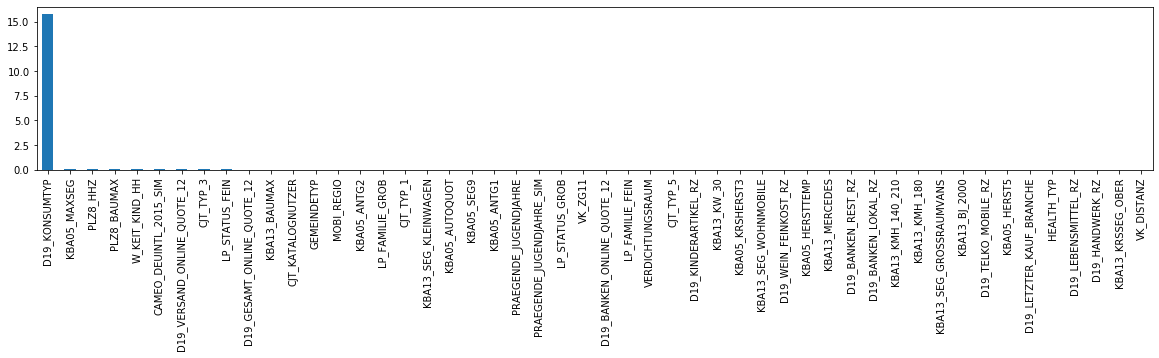

In [28]:
%%time
empty_cells = pd.isnull(joint_dataset_imputed_df).sum()*100.0/joint_dataset_imputed_df.shape[0]
empty_cells = empty_cells.sort_values(ascending=False)
empty_cells[:50].plot(figsize=(20,3),kind='bar') # bar plot of first 50 most missing features

# Second imputation - simple frequency imputer

After we've used a more complicated Bayesian multivariate imputer, we still have a small portion of missing values. We can either remove them, or use a naive imputation method: a scikit-learn instance of SimpleImputer, and replace all missing values with the most frequently occuring one. Since the missingness is small, this would not introduce any big errors. 

Finally we save this dataset as `joint_dataset_imputed.csv` for subsequent analyses.

In [29]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy= 'most_frequent')

joint_dataset_imputed_df = pd.DataFrame(imputer.fit_transform(joint_dataset_imputed_df),columns= joint_dataset_imputed_df.columns)

CPU times: user 457 ms, sys: 28 ms, total: 485 ms
Wall time: 483 ms


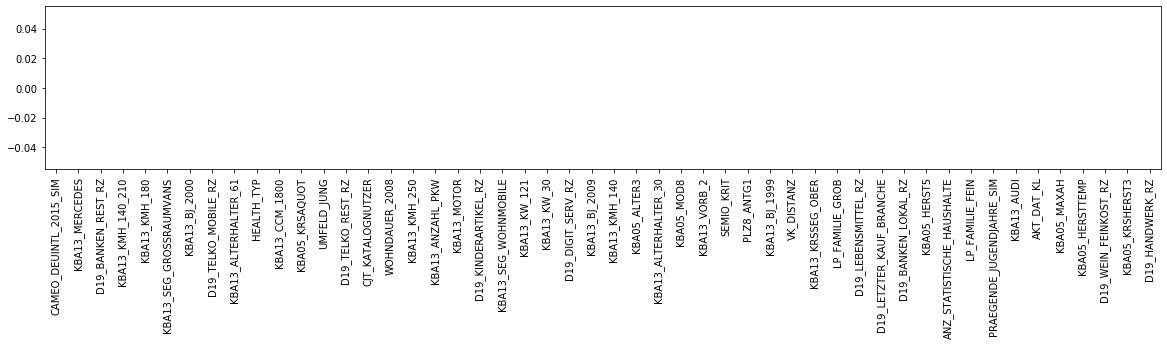

In [30]:
%%time
empty_cells = pd.isnull(joint_dataset_imputed_df).sum()*100.0/joint_dataset_imputed_df.shape[0]
empty_cells = empty_cells.sort_values(ascending=False)
empty_cells[:50].plot(figsize=(20,3),kind='bar') # bar plot of first 50 most missing features

In [31]:
joint_dataset_imputed_df.head()

,WOHNLAGE,KBA13_KW_50,SEMIO_RAT,KBA05_SEG5,FINANZ_HAUSBAUER,FINANZTYP,GEMEINDETYP,KBA13_KRSHERST_AUDI_VW,D19_BUCH_RZ,KBA13_CCM_2500,...,KBA13_HALTER_65,D19_KONSUMTYP_MAX,SEMIO_ERL,KBA13_SITZE_5,KBA13_SITZE_6,KBA13_TOYOTA,GEBAEUDETYP,KBA13_CCM_3001,PRAEGENDE_JUGENDJAHRE_SIM,CAMEO_DEUINTL_2015_SIM
0,6.0,2.0,0.0,3.0,1.0,1.0,6.0,4.0,6.0,4.0,...,3.0,1.0,2.0,0.0,4.0,1.0,0.0,2.0,1.0,0.0
1,2.0,4.0,1.0,1.0,3.0,1.0,3.0,4.0,0.0,2.0,...,2.0,1.0,6.0,2.0,3.0,2.0,6.0,2.0,1.0,2.0
2,6.0,2.0,2.0,0.0,1.0,5.0,5.0,3.0,6.0,3.0,...,0.0,1.0,2.0,2.0,2.0,4.0,1.0,2.0,0.0,1.0
3,3.0,4.0,4.0,1.0,1.0,1.0,3.0,3.0,2.0,0.0,...,2.0,3.0,3.0,1.0,2.0,2.0,2.0,0.0,3.0,3.0
4,1.0,2.0,1.0,4.0,2.0,4.0,1.0,3.0,5.0,5.0,...,2.0,1.0,3.0,1.0,4.0,3.0,0.0,3.0,1.0,2.0


In [32]:
joint_dataset_imputed_df.to_csv("../arvato_data_processed/joint_dataset_imputed.csv")

For unsupervised analysis the dataset needs to be further scaled, but that is going to be applied in the next notebook. 

For now, we have **prepared a final dataset** containing samples (rows) coming from general population (`AZDIAS`) of Germany, and Arvato customers (`customers`). 

For each I've addressed the problems with features: encoded properly the missing values, found feature names that correspond to metadata information including feature names that slightly differ between given data and metadata. I applied filtering per feature and sample based on pre-defined missingness thresholds.

Then, I combined these two datasets into one, found common set of features. I performed feature encoding with `LabelEncoder` to represent categorical and ordinal features with integers. Finally I applied two-step imputation. First a sophisticated IterativeImputer was applied to infer the most likely value for a missing entry using 10 most correlated features. This has proven to be computationally tractable (feasable in a timespan of minutes). Inferred values were converted back to labels using rounding procedure. Finally inferred values that would constitute a new class were replaced with  `NA` and then inferred with `SimpleImputer` using most frequently occuring value. Because later PCA analysis requires all values to be available (i.e. no `NA` values), this approach would provide high retention of values, with removal of highly missing individuals/features for which imputation would not be advised. 